# Understanding Optimization Algorithms with MLP on Fashion MNIST

## Code adapted from https://github.com/phlippe/uvadlc_notebooks/tree/master/docs/tutorial_notebooks/tutorial4

In [95]:
## Standard libraries
import os
import json
import math
import numpy as np 
import copy

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

/var/folders/2v/0s_wd0cd04g3xtcdpppg90980000gn/T/ipykernel_61447/1273435145.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [7]:
device = torch.device("mps") if torch.mps.is_available() else torch.device("cpu")
print("Using device", device)

Using device mps


In [9]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    if torch.mps.is_available():
        torch.mps.manual_seed(seed)

In [11]:
class BaseNetwork(nn.Module): #MLP
    
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        super().__init__()
        
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers) 
        
        self.config = {"act_fn": act_fn.__class__.__name__, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes} 
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        logits = self.layers(x)
        return logits 

In [13]:
CHECKPOINT_PATH = "./saved_models"

def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".tar")

def load_model(model_path, model_name, net=None):
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), "Could not find the config file \"%s\". Are you sure this is the correct path and you have your model config stored here?" % (config_file)
    assert os.path.isfile(model_file), "Could not find the model file \"%s\". Are you sure this is the correct path and you have your model stored here?" % (model_file)
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net
    
def save_model(model, model_path, model_name):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

In [15]:
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

DATASET_PATH = "../data"
# We apply a different normalization to give an expected mean of 0 and a standard deviation of 1 across pixels
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.2861,), (0.3530,))])

train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

In [82]:
def train_model(net, model_name, optim_func, max_epochs=50, batch_size=256, overwrite=False):
    optimizer =  optim_func(net.parameters())
    loss_module = nn.CrossEntropyLoss()
    train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

    results = {"train_scores" : [], "val_scores" : []}
    val_scores = []
    train_losses, train_scores = [], []
    best_val_epoch = -1
    for epoch in range(max_epochs):
        net.train()
        true_preds, count = 0., 0
        t = tqdm(train_loader_local, leave=False)
        for imgs, labels in t:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            preds = net(imgs)
            loss = loss_module(preds, labels)
            loss.backward()
            optimizer.step()
            # Record statistics during training
            true_preds += (preds.argmax(dim=-1) == labels).sum().item()
            count += labels.shape[0]
            t.set_description(f"Epoch {epoch+1}: loss={loss.item():4.2f}")
            train_losses.append(loss.item())
        train_acc = true_preds / count
        train_scores.append(train_acc)

        val_acc = test_model(net, val_loader)
        val_scores.append(val_acc)
        print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

        if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
            print("\t   (New best performance, saving model...)")
            save_model(net, CHECKPOINT_PATH, model_name)
            best_val_epoch = epoch
    
    load_model(CHECKPOINT_PATH, model_name, net=net)
    test_acc = test_model(net, test_loader)
    results = {"test_acc": test_acc, "val_scores": val_scores, "train_losses": train_losses, "train_scores": train_scores}
            
    # Plot a curve of the validation accuracy
    sns.set()
    plt.plot([i for i in range(1,len(results["train_scores"])+1)], results["train_scores"], label="Train")
    plt.plot([i for i in range(1,len(results["val_scores"])+1)], results["val_scores"], label="Val")
    plt.xlabel("Epochs")
    plt.ylabel("Validation accuracy")
    plt.ylim(min(results["val_scores"]), max(results["train_scores"])*1.01)
    plt.title(f"Validation performance of {model_name}")
    plt.legend()
    plt.show()
    plt.close()
    
    print((f" Test accuracy: {results['test_acc']*100.0:4.2f}% ").center(50, "=")+"\n")
    return results

def test_model(net, data_loader):
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc 

In [19]:
class OptimizerTemplate:
    
    def __init__(self, params, lr):
        self.params = list(params) # net.parameters() returns a generator
        self.lr = lr
        
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_() # https://stackoverflow.com/questions/49029247/why-do-we-need-to-call-detach-in-zero-grad, also essential for 2nd order optimizers
                p.grad.zero_()
    
    @torch.no_grad()
    def step(self):
        for p in self.params:
            if p.grad is None:
                continue
            self.update_param(p)
            
    def update_param(self, p):
        # To be implemented in optimizer-specific classes
        raise NotImplementedError

In [21]:
class SGD(OptimizerTemplate):
    
    def __init__(self, params, lr):
        super().__init__(params, lr)
        
    def update_param(self, p):
        p_update = -self.lr * p.grad
        p.add_(p_update) # In-place update

In [23]:
class SGDMomentum(OptimizerTemplate):
    
    def __init__(self, params, lr, momentum=0.0):
        super().__init__(params, lr)
        self.momentum = momentum # Corresponds to beta_1 in the equation above
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params} # Dict to store m_t, since step updates per param, and we need to reference it
        
    def update_param(self, p):
        self.param_momentum[p] = (1 - self.momentum) * p.grad + self.momentum * self.param_momentum[p]
        p_update = -self.lr * self.param_momentum[p]
        p.add_(p_update)

* Adam
    * Algo 
        * $m^{(t)} = \beta_1 m^{(t-1)} + (1 - \beta_1)\cdot g^{(t)}$
        * $v^{(t)} = \beta_2 v^{(t-1)} + (1 - \beta_2)\cdot \left(g^{(t)}\right)^2$
        * $\hat{m}^{(t)} = \frac{m^{(t)}}{1-(\beta_1)^t}, \hat{v}^{(t)} = \frac{v^{(t)}}{1-(\beta_2)^t}$
        * $w^{(t)} = w^{(t-1)} - \frac{\eta}{\sqrt{\hat{v}^{(t)}} + \epsilon}\circ \hat{m}^{(t)}$
    * Intuition:
        * We want the gradients of _each param to have similar norm, note that we're not replacing the overall $\eta$, but rather perturbing each term separately.
            * ToDo: Why?
        * $m^{(t)}$ is an EMA of the gradients
        * $v^{(t)}$ is an EMA of the gradient norms
        * $\epsilon$ is a small constant used to improve numerical stability for very small gradient norms.
        * $1-(\beta_1)^t$ and  $1-(\beta_2)^t$ add as a bias correction term and converge to 1 as $t$ increases.
            * ToDo: Understand more about this.
            * Note that implementation only increments $t$ whenever update_param is called. Curious to know how this interacts with say, dropout. Is this how PyTorch implements Adam?

In [61]:
class Adam(OptimizerTemplate):
    
    def __init__(self, params, lr, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.param_step = {p: 0 for p in self.params} # Remembers "t" for each parameter for bias correction
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        self.param_2nd_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        
    def update_param(self, p):
        self.param_step[p] += 1
        
        self.param_momentum[p] = (1 - self.beta1) * p.grad + self.beta1 * self.param_momentum[p]
        self.param_2nd_momentum[p] = (1 - self.beta2) * (p.grad)**2 + self.beta2 * self.param_2nd_momentum[p]
        
        bias_correction_1 = 1 - self.beta1 ** self.param_step[p]
        bias_correction_2 = 1 - self.beta2 ** self.param_step[p]
        
        p_2nd_mom = self.param_2nd_momentum[p] / bias_correction_2
        p_mom = self.param_momentum[p] / bias_correction_1
        p_lr = self.lr / (torch.sqrt(p_2nd_mom) + self.eps)
        p_update = -p_lr * p_mom
        
        p.add_(p_update)

In [ ]:
base_model = BaseNetwork(act_fn=nn.ReLU(), hidden_sizes=[512,256,256,128])

In [ ]:
SGD_model = copy.deepcopy(base_model).to(device)
SGD_results = train_model(SGD_model, "FashionMNIST_SGD", 
                          lambda params: SGD(params, lr=1e-1), 
                          max_epochs=20, batch_size=256)

In [ ]:
SGDMom_model = copy.deepcopy(base_model).to(device)
SGDMom_results = train_model(SGDMom_model, "FashionMNIST_SGDMom", 
                             lambda params: SGDMomentum(params, lr=1e-1, momentum=0.9), 
                             max_epochs=20, batch_size=256)

  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 78.91%, Validation accuracy: 85.23%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 86.23%, Validation accuracy: 85.63%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 87.59%, Validation accuracy: 87.71%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 88.75%, Validation accuracy: 87.89%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 89.44%, Validation accuracy: 88.37%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 90.28%, Validation accuracy: 88.11%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 90.69%, Validation accuracy: 89.26%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 91.06%, Validation accuracy: 88.74%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 91.37%, Validation accuracy: 88.33%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 92.18%, Validation accuracy: 89.12%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 92.30%, Validation accuracy: 89.23%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 92.58%, Validation accuracy: 88.99%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 92.91%, Validation accuracy: 88.81%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 93.57%, Validation accuracy: 89.52%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 93.84%, Validation accuracy: 89.45%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 93.97%, Validation accuracy: 89.35%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 94.08%, Validation accuracy: 89.08%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 94.77%, Validation accuracy: 89.49%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 94.87%, Validation accuracy: 89.59%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 95.20%, Validation accuracy: 89.39%


/var/folders/2v/0s_wd0cd04g3xtcdpppg90980000gn/T/ipykernel_61447/2804802450.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_file, m

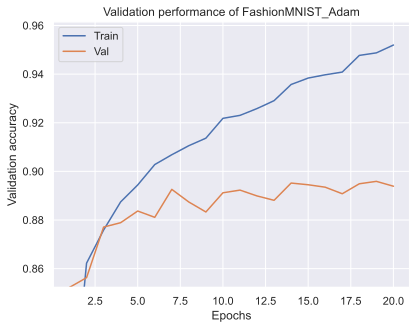

============= Test accuracy: 88.85% ==============



In [89]:
Adam_model = copy.deepcopy(base_model).to(device)
Adam_results = train_model(Adam_model, "FashionMNIST_Adam", 
                           lambda params: Adam(params, lr=1e-3), 
                           max_epochs=20, batch_size=256)

"When changing the initialization to (something) worse (e.g. constant initialization), Adam usually shows to be more robust because of its adaptive learning rate"

### Pathological curvatures

A pathological curvature is a type of surface that is similar to ravines and is particularly tricky for plain SGD optimization. In words, pathological curvatures typically have a steep gradient in one direction with an optimum at the center, while in a second direction we have a slower gradient towards a (global) optimum. 

In [92]:
def pathological_curve_loss(w1, w2):
    x1_loss = torch.tanh(w1)**2 + 0.01 * torch.abs(w1)
    x2_loss = torch.sigmoid(w2)
    return x1_loss + x2_loss

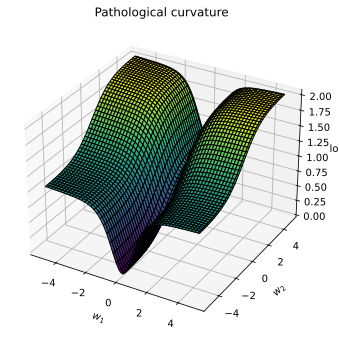

In [97]:
def plot_curve(curve_fn, x_range=(-5,5), y_range=(-5,5), plot_3d=False, cmap=cm.viridis, title="Pathological curvature"):
    fig = plt.figure()
    ax = plt.axes(projection='3d') if plot_3d else plt.axes()
    
    x = torch.arange(x_range[0], x_range[1], (x_range[1]-x_range[0])/100.)
    y = torch.arange(y_range[0], y_range[1], (y_range[1]-y_range[0])/100.)
    x, y = torch.meshgrid(x, y, indexing='xy')
    z = curve_fn(x, y)
    x, y, z = x.numpy(), y.numpy(), z.numpy()
    
    if plot_3d:
        ax.plot_surface(x, y, z, cmap=cmap, linewidth=1, color="#000", antialiased=False)
        ax.set_zlabel("loss")
    else:
        ax.imshow(z[::-1], cmap=cmap, extent=(x_range[0], x_range[1], y_range[0], y_range[1]))
    plt.title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    plt.tight_layout()
    return ax

sns.reset_orig()
_ = plot_curve(pathological_curve_loss, plot_3d=True)
plt.show()

In [101]:
def train_curve(optimizer_func, curve_func=pathological_curve_loss, num_updates=100, init=[5,5]):
    weights = nn.Parameter(torch.FloatTensor(init), requires_grad=True)
    optimizer = optimizer_func([weights])
    
    list_points = []
    for _ in range(num_updates):
        loss = curve_func(weights[0], weights[1])
        list_points.append(torch.cat([weights.data.detach(), loss.unsqueeze(dim=0).detach()], dim=0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    points = torch.stack(list_points, dim=0).numpy()
    return points

In [103]:
SGD_points = train_curve(lambda params: SGD(params, lr=10))
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=10, momentum=0.9))
Adam_points = train_curve(lambda params: Adam(params, lr=1))

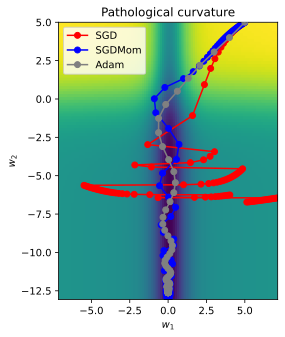

In [105]:
all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)
ax = plot_curve(pathological_curve_loss,
                x_range=(-np.absolute(all_points[:,0]).max(), np.absolute(all_points[:,0]).max()),
                y_range=(all_points[:,1].min(), all_points[:,1].max()),
                plot_3d=False)
ax.plot(SGD_points[:,0], SGD_points[:,1], color="red", marker="o", zorder=1, label="SGD")
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="blue", marker="o", zorder=2, label="SGDMom")
ax.plot(Adam_points[:,0], Adam_points[:,1], color="grey", marker="o", zorder=3, label="Adam")
plt.legend()
plt.show()

SGD oscillates while algorithms with momentum nicely converge because the changing direction of the gradient is canceling itself out.

### Steep optima

A second type of challenging loss surfaces are steep optima. In those, we have a larger part of the surface having very small gradients while around the optimum, we have very large gradients.

In [111]:
def bivar_gaussian(w1, w2, x_mean=0.0, y_mean=0.0, x_sig=1.0, y_sig=1.0):
    norm = 1 / (2 * np.pi * x_sig * y_sig)
    x_exp = (-1 * (w1 - x_mean)**2) / (2 * x_sig**2)
    y_exp = (-1 * (w2 - y_mean)**2) / (2 * y_sig**2)
    return norm * torch.exp(x_exp + y_exp)

def comb_func(w1, w2):
    z = -bivar_gaussian(w1, w2, x_mean=1.0, y_mean=-0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-1.0, y_mean=0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-0.5, y_mean=-0.8, x_sig=0.2, y_sig=0.2)
    return z

_ = plot_curve(comb_func, x_range=(-2,2), y_range=(-2,2), plot_3d=True, title="Steep optima")

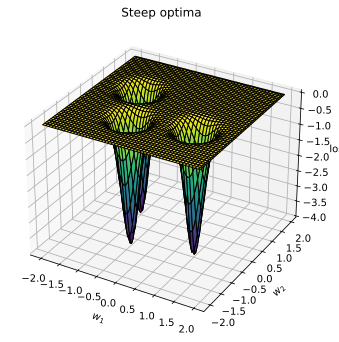

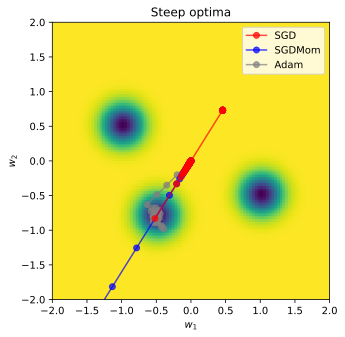

In [113]:
SGD_points = train_curve(lambda params: SGD(params, lr=.5), comb_func, init=[0,0])
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=1, momentum=0.9), comb_func, init=[0,0])
Adam_points = train_curve(lambda params: Adam(params, lr=0.2), comb_func, init=[0,0])

all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)
ax = plot_curve(comb_func,
                x_range=(-2, 2),
                y_range=(-2, 2),
                plot_3d=False,
                title="Steep optima")
ax.plot(SGD_points[:,0], SGD_points[:,1], color="red", marker="o", zorder=3, label="SGD", alpha=0.7)
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="blue", marker="o", zorder=2, label="SGDMom", alpha=0.7)
ax.plot(Adam_points[:,0], Adam_points[:,1], color="grey", marker="o", zorder=1, label="Adam", alpha=0.7)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.legend()
plt.show()

* SGD: Touches steep gradient and then overshoots
* SGDM: Momentum overshoots
* Adam: Adaptive learning rate allows it to stay in minimum - why?

## SGD vs Adam
* Adam is the most commonly used optimizer in Deep Learning as it usually performs better than other optimizers, especially for deep networks
* But there are scenarios that SGD (with momentum) may generalize better as Adam tends to overfit.